In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
from folium.plugins import HeatMap
from datetime import datetime
from datetime import timedelta
from sklearn import preprocessing

In [2]:
brm = pd.read_csv("../resources/bremen.csv")
frb = pd.read_csv("../resources/freiburg.csv")

brm_hourly_driven = pd.read_csv("../generated/brm_hourly_driven.csv")
frb_hourly_driven = pd.read_csv("../generated/frb_hourly_driven.csv")

brm_hourly_weather = pd.read_csv("../generated/brm_hourly_weather.csv")
frb_hourly_weather = pd.read_csv("../generated/frb_hourly_weather.csv")

In [3]:
brm_hourly_driven["trip_duration"] = brm_hourly_driven["trip_duration"].apply(pd.Timedelta)
frb_hourly_driven["trip_duration"] = frb_hourly_driven["trip_duration"].apply(pd.Timedelta)

In [4]:
brm_hourly_combined = brm_hourly_weather.join(brm_hourly_driven["trip_duration"])
frb_hourly_combined = frb_hourly_weather.join(frb_hourly_driven["trip_duration"])

In [5]:
brm_daily = brm_hourly_combined.groupby("day").agg({"trip_duration":"sum","precipitation":"sum","temperature":"mean"})
brm_daily["trip_duration_in_hours"] = brm_daily["trip_duration"].map(lambda x: (x.total_seconds() / 60 / 60))

In [6]:
brm_daily = brm_daily.reset_index()
brm_daily["day"] = pd.to_datetime(brm_daily["day"])
brm_daily["week"] = brm_daily["day"].map(lambda x: (x.strftime("%V")))
brm_daily["year"] = brm_daily["day"].map(lambda x: (x.strftime("%Y")))

In [7]:
brm_daily_values = brm_daily[["precipitation","temperature","trip_duration_in_hours"]].values

In [8]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
brm_daily_scaled = min_max_scaler.fit_transform(brm_daily_values)
daily_demand = pd.DataFrame(brm_daily_scaled)

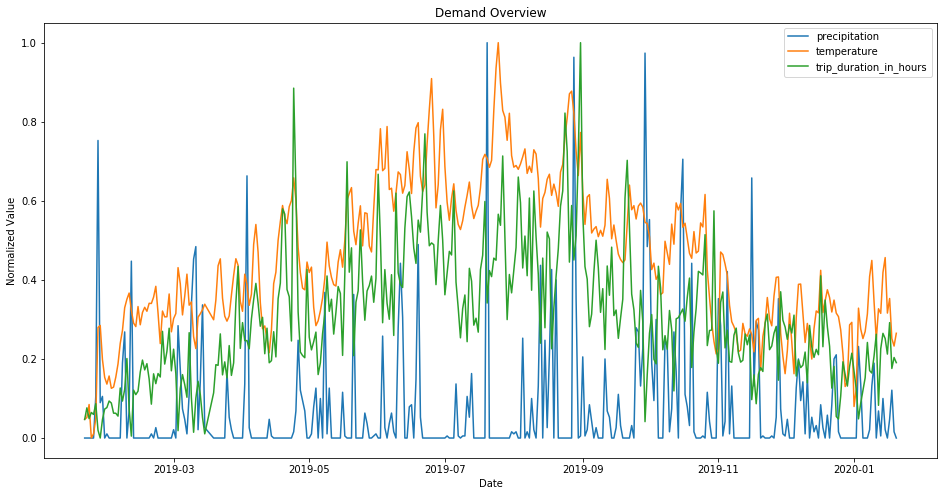

In [9]:
plt.figure(figsize=(16,8))
plt.plot(brm_daily["day"],daily_demand[0],label = "precipitation")
plt.plot(brm_daily["day"],daily_demand[1],label = "temperature")
plt.plot(brm_daily["day"],daily_demand[2],label = "trip_duration_in_hours")
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Demand Overview')
plt.legend()
plt.show()

In [10]:
brm_weekly = brm_daily.groupby(["year","week"]).agg({"trip_duration":"sum","precipitation":"sum","temperature":"mean"})
brm_weekly["trip_duration_in_hours"] = brm_weekly["trip_duration"].map(lambda x: (x.total_seconds() / 60 / 60))

In [11]:
brm_weekly_values = brm_weekly[["precipitation","temperature","trip_duration_in_hours"]].values

In [12]:
brm_weekly_scaled = min_max_scaler.fit_transform(brm_weekly_values)
weekly_demand = pd.DataFrame(brm_weekly_scaled)
brm_weekly = brm_weekly.reset_index()

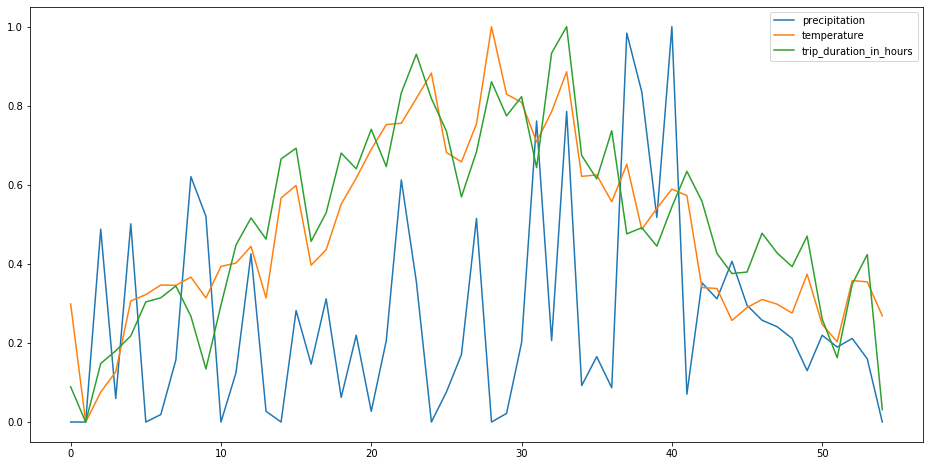

In [13]:
plt.figure(figsize=(16,8))
plt.plot(brm_weekly.index,weekly_demand[0],label = "precipitation")
plt.plot(brm_weekly.index,weekly_demand[1],label = "temperature")
plt.plot(brm_weekly.index,weekly_demand[2],label = "trip_duration_in_hours")
plt.legend()
plt.show()